In [114]:
import cv2
import csv
import os
import time
import numpy as np
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from collections import defaultdict

CSV_PATH = "/home/paolobif/Lab-Work/ml/pre_arch/worm_data/compiled_11_20/compiled_11_20.csv"
IMAGE_PATH = "/home/paolobif/Lab-Work/ml/pre_arch/worm_data/compiled_11_20/NN_posttrain_2_im/"


In [115]:
def load_csv(PATH):
    data = [] #(name, x_uppr, y_uppr, w, h)
    with open(PATH, newline="") as csvfile:
        csvfile = csv.reader(csvfile)
        for file in csvfile:
            if file not in data: #checks for duplicates. this step is slow.
            # quick fix for no_worm in csv
                if file[1] == "no_worms":
                    pass
                else:
                    data.append(file)
            else:
                pass
    return(data)


csv_ar = load_csv(CSV_PATH)
csv_ar = csv_ar[1:]

In [116]:
def dictionize_csv(csv_ar):
    dict_info = {}
    for row in csv_ar:
        img_name = row[0]
        dict_info.setdefault(img_name, []).append(row[1:])
    return dict_info

data_ar = dictionize_csv(csv_ar)
img_names = os.listdir(IMAGE_PATH)

In [117]:
## creates maping generator object
class MapGenerator():
    """ Class generates a map grid with the specified cuts
        Takes an imput of either image or xy tuple"""
    def __init__(self, xy_shape, cut_size):
        self.cut_size = cut_size
        if type(xy_shape) != tuple:
            print("input is an np img array")
            self.xy_shape = (xy_shape.shape[1], xy_shape.shape[0])
            #self.x_shape = img_xy.shape[1]
        else:
            self.xy_shape = xy_shape
            #self.y_shape = img_xy[1]
        
        self.paired_grid = []
        
        self.map_grid = self.generate_complete_map_grid()
    
    def generate_complete_map_grid(self):
        """Four passes of map_grid need to be run in order
        to cover entire area. Returns list of points for bounds. """
        xy_shape = self.xy_shape
        cut_size = self.cut_size
        
        shiftx = int(self.cut_size/2) 
        shifty = int(self.cut_size/2)
        
        pass1 = self.map_ar(xy_shape, cut_size, (0,0))
        pass2 = self.map_ar(xy_shape, cut_size, (shiftx, shifty))
        pass3 = self.map_ar(xy_shape, cut_size, (shiftx, 0))
        pass4 = self.map_ar(xy_shape, cut_size, (0, shifty))
        self.map_grids = [pass1, pass2, pass3, pass4]
        
        complete_map_grid = []
        for map_grid in self.map_grids:
            paired_corners = self.convert_grid_to_cornerxy(map_grid)
            self.paired_grid.append(paired_corners)
            complete_map_grid.extend(paired_corners)
            
        return complete_map_grid
        
        # shiftxy can be modified when calling map_ar to create different arrangements of rectangles
        
    @staticmethod
    def map_ar(xy_shape, cut_size, shiftxy=(0,0)):
        """creates grid map for slicing - adjust shift to cover needed areas -current method
        is shift=(cut_size/2, cut_size/2) and (0, cut_size/2) and (cut_size, 0/2).
        IMPORTANT - cut_size must be div by 2"""
        x_size = xy_shape[0]
        y_size = xy_shape[1]    

        x_shift = shiftxy[0]
        y_shift = shiftxy[1]

        map_ar = []

        # declare ranges
        x_start_range = 0 + x_shift
        y_start_range = 0 + y_shift

        # determines the range of each cut. 
        second_pass_shift = (int(cut_size/2), int(cut_size/2)) 
        x_max_range = x_size + cut_size if shiftxy == (0,0) or shiftxy == second_pass_shift else x_size
        y_max_range = y_size + cut_size if shiftxy == (0,0) or shiftxy == second_pass_shift else y_size

        for x in range(0+x_shift, x_max_range, cut_size):
            for y in range(0+y_shift, y_max_range, cut_size):
                map_ar.append([x,y])

        return map_ar
    
    @staticmethod
    def convert_grid_to_cornerxy(map_grid):
        """ Takes the series of points and then returns point (x1,y1), (x2,y2) for each rectangle"""
        only_xs = [n[0] for n in map_grid]
        y_slice_count = only_xs.count(only_xs[0])
               
        paired_corners = []
        ## pair index is the matching corner to point
        for i, point in enumerate(map_grid):
            pair_index = i+y_slice_count+1
            
            # if the pair index is not the last of each chunck or the last group do ...
            if (i+1) % y_slice_count != 0 and pair_index <= len(map_grid):
                #print(i, pair_index, f"division:{(i+1)%y_slice_count}")
                pair = map_grid[pair_index]
                paired_corners.append([tuple(point), tuple(pair)])
            else:
                pass
            
        return(paired_corners)
        

In [162]:
class CutImage(MapGenerator):
    """Processes Single Image - cuts it according to cut_size, set 
    training True and itll correctly allocate bounding boxes from bb_list: [x_corner,y_corner,w,h]"""
    def __init__(self, img, cut_size, Training=False, bb_list=None):
        """important property is map_grid from MapGenreator - maps where to cut image"""
        MapGenerator.__init__(self, img, cut_size)
        self.img = img
        self.Training = Training
        self.bb_list = bb_list
    
    def cut_image(self):
        # cuts image according to map_grid and returns dict with img and keys
        img_cuts = {}
        for xy_pair in self.map_grid:
            x1y1, x2y2 = xy_pair
            x1, y1 = x1y1
            x2, y2 = x2y2 
            
            img_crop = self.img[y1:y2, x1:x2]
            
            # add padding if the image is not sized correctly
            if img_crop.shape != (self.cut_size, self.cut_size):
                img_crop = self.add_padding_to_square_img(img_crop, self.cut_size)
            
            img_cuts.setdefault("keys", []).append(xy_pair)
            img_cuts.setdefault("imgs", []).append(img_crop)
            if self.Training == True:
                bbs_in_frame = self.check_if_bb_in_frame(x1y1, x2y2)
                img_cuts.setdefault("bbs", []).append(bbs_in_frame)
        
        return img_cuts
    
    def check_if_bb_in_frame(self, x1y1, x2y2):
        """Finds bounding boxes within the frame bounds and returns list of bbs"""
        bbs_in_frame = []
        for bb in self.bb_list:
            bb = [int(n) for n in bb]
            xcorner, ycorner, w, h = bb
            worm_x1y1, worm_x2y2 = (xcorner, ycorner), (xcorner+w, ycorner+h)
            
            test = {"worm_x1y1":False, "worm_x2y2":False}
            if self.point_is_within_bounds(worm_x1y1, x1y1, x2y2): test["worm_x1y1"] = True
            if self.point_is_within_bounds(worm_x2y2, x1y1, x2y2): test["worm_x2y2"] = True
            
            #print(test, bb, x1y1, x2y2)
            ## set only one to be true if you want to include bbs that are partially within frame
            if test["worm_x1y1"] == True and test["worm_x2y2"] == True:
                # adjust for shift in position after cutting
                adj_x = xcorner - x1y1[0]
                adj_y = ycorner - x1y1[1]
                bbs_in_frame.append([adj_x, adj_y, w, h])
                #print(bb, test)

        return bbs_in_frame
    
    @staticmethod
    def add_padding_to_square_img(img, cut_size):
        y_size, x_size = img.shape[:2]
        y_pad_amount = cut_size - y_size
        x_pad_amount = cut_size - x_size

        pad_img = np.pad(img, [(0,y_pad_amount), (0,x_pad_amount), (0,0)])
        
        return pad_img
    
    @staticmethod
    def point_is_within_bounds(worm_xy, x1y1, x2y2):
        #checks if one corner of the worm bb is within the frame
        #if a single point is out of frame the worm is excluded
        if worm_xy[0] >= x1y1[0] and worm_xy[0] <= x2y2[0]:
            if worm_xy[1] >= x1y1[1] and worm_xy[1] <= x2y2[1]:
                return True
        else: 
            return False
    
        

In [163]:
CUT_SIZE = 416

img1 = cv2.imread(IMAGE_PATH+img_names[1])
bb1_list = data_ar[img_names[1]]

tic = time.process_time()

a = CutImage(img1, CUT_SIZE, Training=True, bb_list=bb1_list)

toc = time.process_time()

print(f"Elapsed Time: {toc-tic}")


input is an np img array
Elapsed Time: 0.0003599280000017302


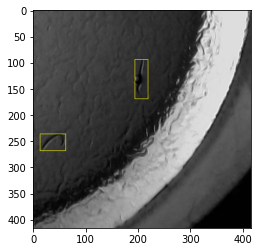

In [184]:
test = a.cut_image()
def test_img_output(n, dic):
    im = dic['imgs'][n]
    bbs = dic['bbs'][n]
    keys = dic['keys'][n]
    
    for bb in bbs:
        x1, y1 = bb[0], bb[1]
        x2, y2 = x1 + bb[2], y1 + bb[3]
        
        cv2.rectangle(im, (x1, y1), (x2, y2), (255,255,0))
    
    return im

im = test_img_output(22, test)

plt.imshow(im)